In [47]:
import os
import zipfile

local_zip = '/tmp/surprise_and_confusion_face.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [48]:
base_dir = '/tmp/surprise_and_confusion_face'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_confusion_dir = os.path.join(train_dir, 'confusion')

# Directory with our training dog pictures
train_surprise_dir = os.path.join(train_dir, 'surprise')

# Directory with our validation cat pictures
validation_confusion_dir = os.path.join(validation_dir, 'confusion')

# Directory with our validation dog pictures
validation_surprise_dir = os.path.join(validation_dir, 'surprise')

In [49]:
train_confuse_fnames = os.listdir(train_confusion_dir)
print(train_confuse_fnames[:10])

train_surpris_fnames = os.listdir(train_surprise_dir)
train_surpris_fnames.sort()
print(train_surpris_fnames[:10])

['images (85).jpg', 'images (73).jpg', 'images (7).jpg', 'images (22).jpg', 'images (40).jpg', 'istockphoto-896823196-612x612.jpg', 'images (34).jpg', 'images (33).jpg', 'images (52).jpg', 'istockphoto-1187585016-612x612.jpg']
['images (100).jpg', 'images (12).jpg', 'images (13).jpg', 'images (15).jpg', 'images (16).jpg', 'images (17).jpg', 'images (18).jpg', 'images (19).jpg', 'images (20).jpg', 'images (21).jpg']


In [50]:
print('total training confuse images:', len(os.listdir(train_confusion_dir)))
print('total training surpris images:', len(os.listdir(train_surprise_dir)))
print('total validation confuse images:', len(os.listdir(validation_confusion_dir)))
print('total validation surpris images:', len(os.listdir(validation_surprise_dir)))

total training confuse images: 130
total training surpris images: 150
total validation confuse images: 51
total validation surpris images: 75


In [51]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

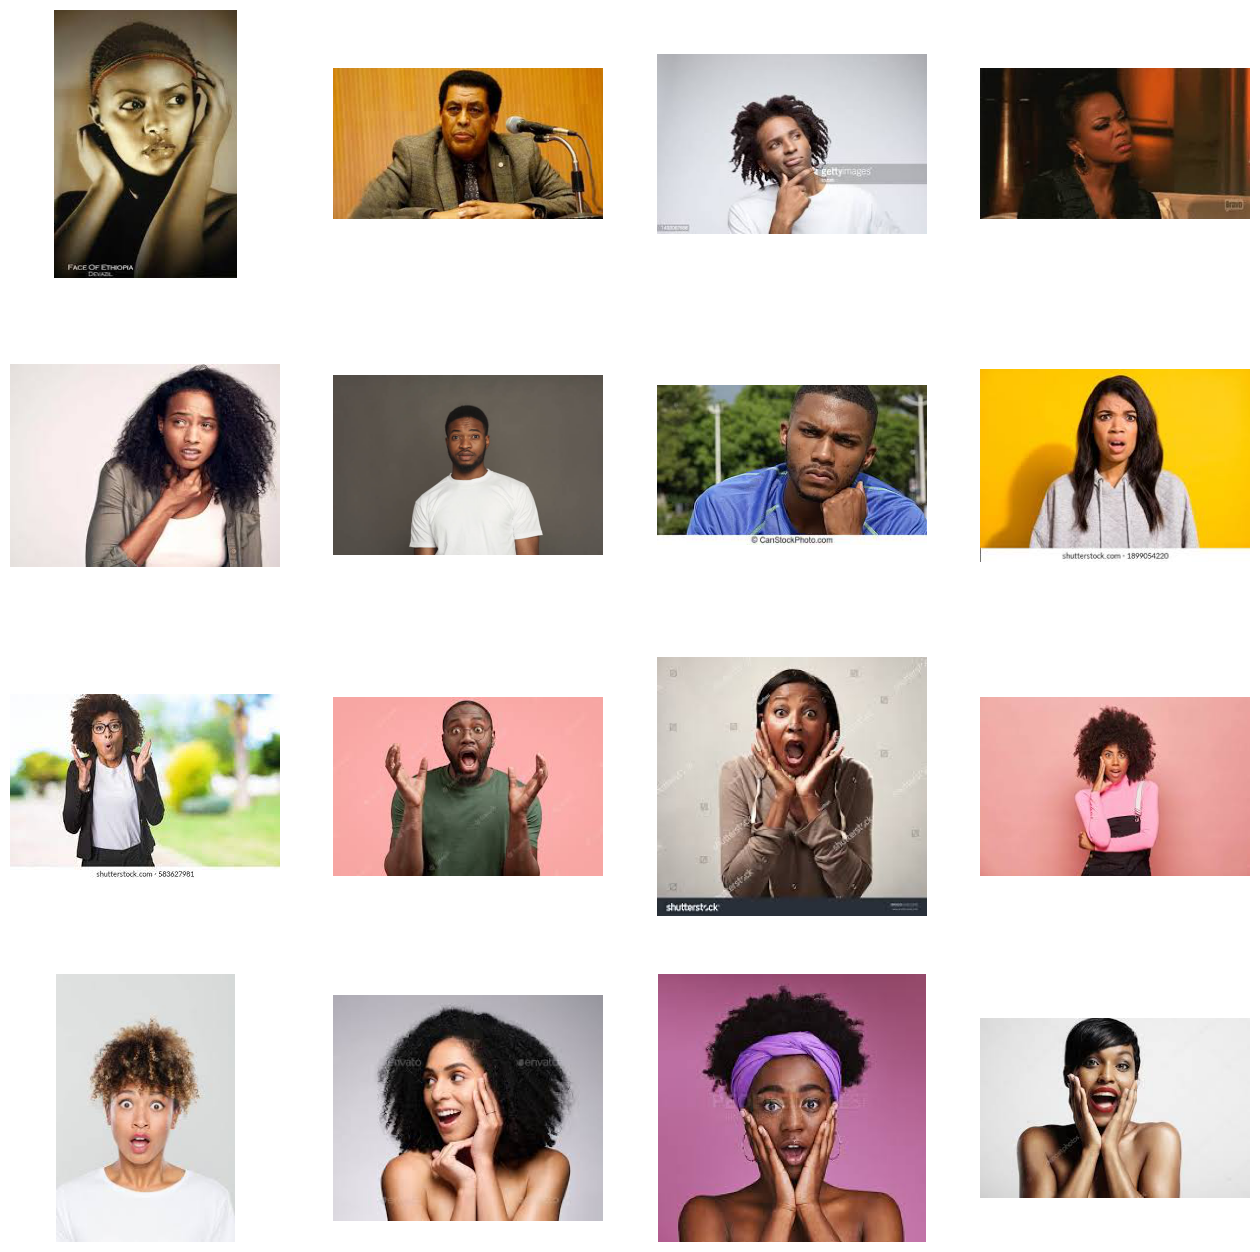

In [52]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_confuse_pix = [os.path.join(train_confusion_dir, fname) 
                for fname in train_confuse_fnames[pic_index-8:pic_index]]
next_surpris_pix = [os.path.join(train_surprise_dir, fname) 
                for fname in train_surpris_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_confuse_pix+next_surpris_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [53]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [54]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

In [55]:
# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully 
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [56]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        1849

In [57]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [58]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 280 images belonging to 2 classes.
Found 125 images belonging to 2 classes.


In [66]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  # 2000 images = batch_size * steps
      epochs=10,
      validation_data=validation_generator,
      validation_steps=5,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/10


<ipython-input-66-301da20e2947>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


10/10 - 8s - loss: 0.4952 - acc: 0.7600 - val_loss: 0.6776 - val_acc: 0.6400 - 8s/epoch - 787ms/step
Epoch 2/10
10/10 - 6s - loss: 0.4270 - acc: 0.8250 - val_loss: 0.7438 - val_acc: 0.6400 - 6s/epoch - 641ms/step
Epoch 3/10
10/10 - 6s - loss: 0.4135 - acc: 0.8000 - val_loss: 0.7382 - val_acc: 0.6100 - 6s/epoch - 594ms/step
Epoch 4/10
10/10 - 7s - loss: 0.3987 - acc: 0.8300 - val_loss: 0.7724 - val_acc: 0.6200 - 7s/epoch - 721ms/step
Epoch 5/10
10/10 - 6s - loss: 0.1992 - acc: 0.9350 - val_loss: 0.9260 - val_acc: 0.5900 - 6s/epoch - 646ms/step
Epoch 6/10
10/10 - 6s - loss: 0.3003 - acc: 0.8800 - val_loss: 0.8327 - val_acc: 0.6200 - 6s/epoch - 645ms/step
Epoch 7/10
10/10 - 7s - loss: 0.1415 - acc: 0.9650 - val_loss: 1.1567 - val_acc: 0.6100 - 7s/epoch - 715ms/step
Epoch 8/10
10/10 - 8s - loss: 0.1545 - acc: 0.9500 - val_loss: 1.9584 - val_acc: 0.4900 - 8s/epoch - 812ms/step
Epoch 9/10
10/10 - 6s - loss: 0.1089 - acc: 0.9750 - val_loss: 1.2440 - val_acc: 0.6800 - 6s/epoch - 643ms/step
Epo

1/1 [==============================] - 0s 94ms/step


<ipython-input-67-2e4cb7e5eec9>:43: RuntimeWarning: invalid value encountered in true_divide
  x /= x.std()


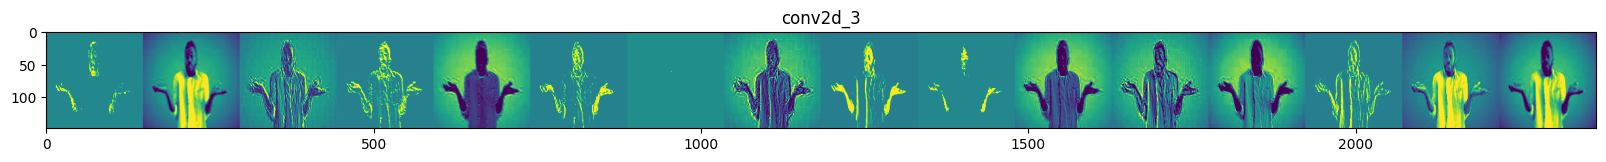

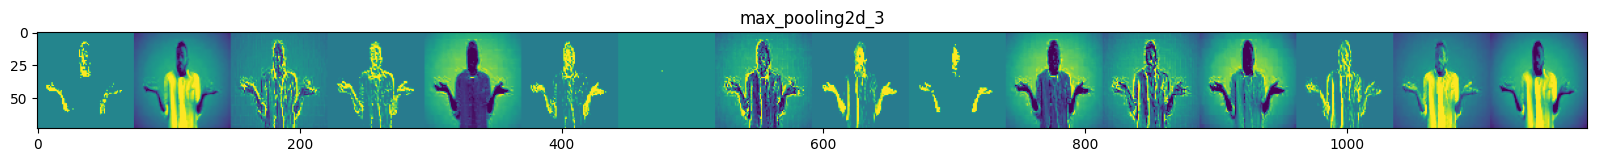

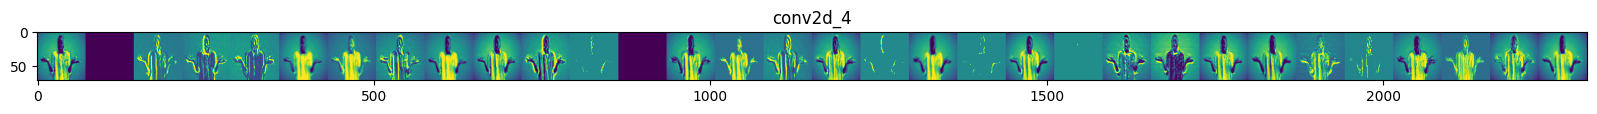

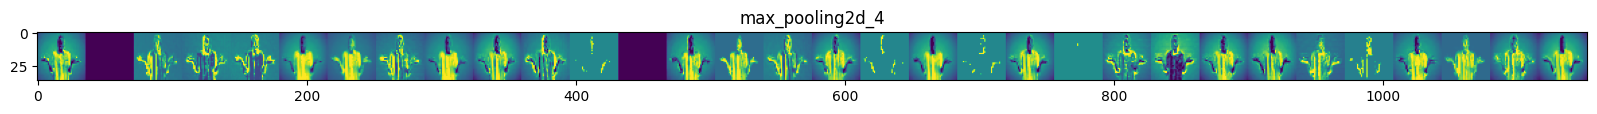

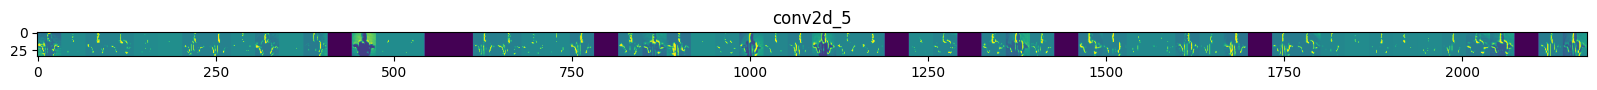

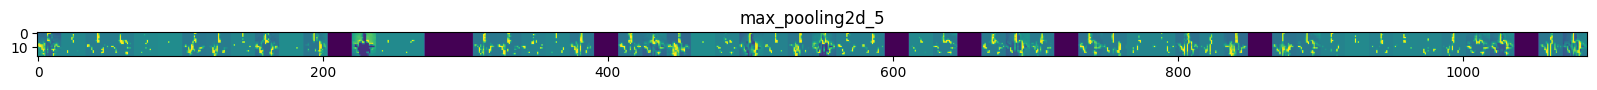

In [67]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
confuse_img_files = [os.path.join(train_confusion_dir, f) for f in train_confuse_fnames]
surpris_img_files = [os.path.join(train_surprise_dir, f) for f in train_surpris_fnames]
img_path = random.choice(confuse_img_files + surpris_img_files)

img = load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Text(0.5, 1.0, 'Training and validation loss')

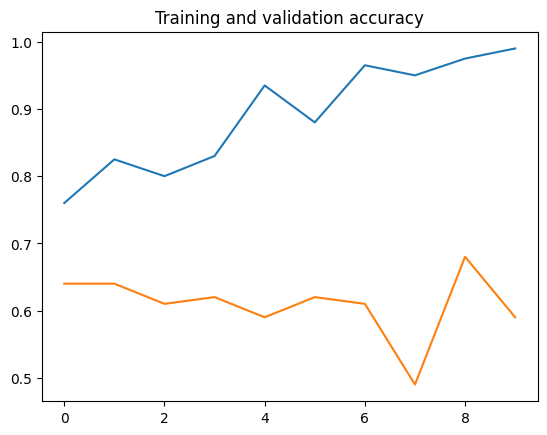

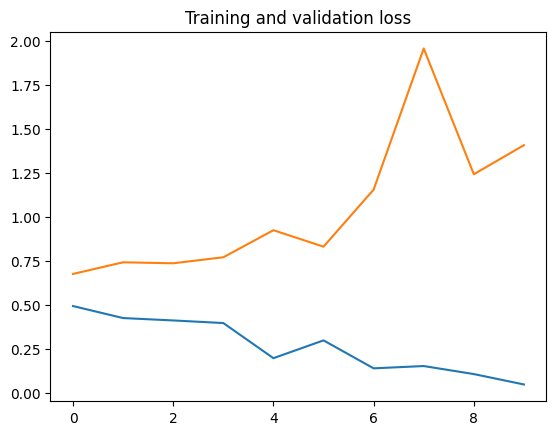

In [68]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')